# Capstone Project - Customized Suggestions for Travelers
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

In  this project we'll group cities by checking similarities between  their venues categories. This study target travel agencies which are interested in make customized suggestions to its clients.
Since there are lots of spots around the world we'll focus on most visited cities. We'll consider just cities which have currently a positive growth in tourist arrivals. We are also interested in venues located near city centers and their categories.

We'll use data science skills to cluster cities in similar groups based  on their venues categories. Each group will be labeled based on their touristic characteristics. Doing so, stakeholders will be able to suggest cities which are in line with client's preferences.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our solution are:
 
* Number of venues within five kilometers from city centers
* Arrivals growth rates

We decided to use ranking provided by Euromonitor of most visited cities in the world.

Following data sources will be needed to generate the required solution:

* List of top 100 cities ranked by the number of international visitors provided by Euromonitor
* Latitudes and longitudes of city centers, obtained using Nominatim/Geopy library
* Venues around city centers provided by Foursquare API
* Classification of each Foursquare categories by tourism types

Before starting let's import all dependencies used in this project.

In [1]:
import pandas as pd # library to handle dataframes
import seaborn as sns # library to handle data visualization
import numpy as np # library to handle arrays
import folium # library to handle maps
import json # library to handle JSON files
import requests # library to handle requests
from sklearn.cluster import KMeans # machine learning algorithms
import matplotlib.pyplot as plt # plotting tool
import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install pycountry_convert 
import pycountry_convert as pc # library to convert countries/continents codes
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude
#!pip install lxml
import lxml # library to handle html

print('Libraries Imported')

Libraries Imported


### City Candidates

We will scrape Wikipedia to get **Euromonitor** ranking of most visited cities. Euromonitor define a foreign visitor as a person who spends at least 24 hours in a city. For cities bordering directly on foreign territory,  border crossings from country to country are not counted.

In [64]:
top_cities = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors')
top_cities = top_cities[0]
top_cities.head()

,RankEuromonitor,RankMastercard,City,Country,Arrivals 2017Euromonitor,Arrivals 2016Mastercard,Growthin arrivalsEuromonitor,Income(billions $)Mastercard
0,1.0,11.0,Hong Kong,Hong Kong,25695800.0,8370000.0,−3.1 %,6.84
1,2.0,1.0,Bangkok,Thailand,23270600.0,21470000.0,9.5 %,14.84
2,3.0,2.0,London,United Kingdom,19842800.0,19880000.0,3.4 %,19.76
3,4.0,6.0,Singapore,Singapore,17681800.0,12110000.0,6.1 %,12.54
4,5.0,NaN,Macau,Macau,16299100.0,NaN,5.9 %,NaN


Wikipedia provides two rankings. We are interested in Euromonitor's ranking, so let's drop all Mastercard's information. Also, let's drop all cities which belongs only to Mastercard's ranking.

In [65]:
top_cities = top_cities[top_cities['RankEuromonitor'].notnull()]
top_cities.drop(['RankMastercard', 'Income(billions $)Mastercard', 'Arrivals 2016Mastercard'], axis=1, inplace=True)
print('Now we have just {} cities in our dataframe!'.format(top_cities.shape[0]))

Now we have just 100 cities in our dataframe!


To this project the position in the ranking and number of arrivals are not important. We will also drop them and rename columns for better understanding.

In [66]:
top_cities.drop(['RankEuromonitor', 'Arrivals 2017Euromonitor'], axis=1, inplace=True)
top_cities.columns = ['City', 'Country', 'Arr_growth']
top_cities.reset_index(drop=True)
top_cities.head()

,City,Country,Arr_growth
0,Hong Kong,Hong Kong,−3.1 %
1,Bangkok,Thailand,9.5 %
2,London,United Kingdom,3.4 %
3,Singapore,Singapore,6.1 %
4,Macau,Macau,5.9 %


Let's check column types.

In [67]:
top_cities.dtypes

City          object
Country       object
Arr_growth    object
dtype: object

As we are interested only in cities with positive growth arrivals rate, let's cast **Arr_growth** to float.

In [68]:
top_cities['Arr_growth'] = top_cities['Arr_growth'].replace('%','', regex=True)
top_cities['Arr_growth'] = top_cities['Arr_growth'].replace(',','.', regex=True)
top_cities['Arr_growth'] = top_cities['Arr_growth'].replace('−','-', regex=True).astype(float)
top_cities.dtypes

City           object
Country        object
Arr_growth    float64
dtype: object

Great, it's float now! Now let's take off all cities which have growth arrival rate below zero. 

In [69]:
top_cities = top_cities.drop(top_cities[(top_cities['Arr_growth'] < 0)].index)

### Geo-spacial Reference

Now let's use pycountry_convert library to search continent information of each city.

In [70]:
top_cities['Continent'] = ''

for i, row in top_cities.iterrows():
    country_code = pc.country_name_to_country_alpha2(row['Country'], cn_name_format="default") 
    continent_name  = pc.country_alpha2_to_continent_code(country_code)
    top_cities.loc[i, 'Continent'] = continent_name
    
top_cities['Continent'].value_counts()

AS    44
EU    25
NA    12
OC     3
AF     3
SA     1
Name: Continent, dtype: int64

Pycountry_convert assumes that North America (NA) and South America (SA) are different continents. Let's put them together and label them as AM ('America').

In [71]:
top_cities['Continent'].replace('NA', 'AM', inplace=True)
top_cities['Continent'].replace('SA', 'AM', inplace=True)
top_cities['Continent'].value_counts()

AS    44
EU    25
AM    13
OC     3
AF     3
Name: Continent, dtype: int64

Finally, let's get latitudes and longitudes for each city. To do so we are going to use Geopy library and them visualize our set of cities in the map.

In [72]:
geolocator = Nominatim(user_agent="explorer")

top_cities['Lat'] = float(0)
top_cities['Lng'] = float(0)

for i, row in top_cities.iterrows():
    location = geolocator.geocode(str(row['City'] + ', ' + row['Country']))
    top_cities.loc[i, 'Lat'] = location.latitude
    top_cities.loc[i, 'Lng'] = location.longitude

top_cities.head()

,City,Country,Arr_growth,Continent,Lat,Lng
1,Bangkok,Thailand,9.5,AS,13.753893,100.816080
2,London,United Kingdom,3.4,EU,51.507322,-0.127647
3,Singapore,Singapore,6.1,AS,1.340863,103.830392
4,Macau,Macau,5.9,AS,22.195629,113.548785
5,Dubai,United Arab Emirates,7.7,AS,25.075010,55.188761


In [ ]:
world_map = folium.Map(location=[0,25], zoom_start = 2)
    
# add cities to map
for lat, lng, city in zip(top_cities['Lat'], 
                        top_cities['Lng'], 
                        top_cities['City']):
    
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(world_map)  
        
world_map

![](Data Science Project/Resources/cluster_map.PNG) 

Now we are going to use Foursquare API to search for venues around city centers. First we'll build a function to loop over **top_cities** using Foursquare function **explore**.

In [96]:
# setting API credentials
client_id = '______________________________________' # Foursquare ID
client_secret = '______________________________________' # Foursquare Secret
version = '20180605' # Foursquare API version


def getNearbyVenues(cities, latitudes, longitudes, radius=5000, limit=100):

    venues_list=[]
    
    for city, lat, lng in zip(cities, latitudes, longitudes):
        print('Searching near', city)
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City_lat', 
                  'City_lng', 
                  'Venue', 
                  'Venue_lat', 
                  'Venue_lng', 
                  'Category_ID']
    
    return(nearby_venues)

Now we are able to get list of venues near the city centers. As Foursquare API return up to 100 venues per call, this will be maximum number of venues per city.

In [78]:
top_cities_venues = getNearbyVenues(cities=top_cities['City'], 
                                latitudes=top_cities['Lat'],
                                longitudes=top_cities['Lng'])

top_cities_venues.head()

Searching near Bangkok
Searching near London
Searching near Singapore
Searching near Macau
Searching near Dubai
Searching near New York City
Searching near Shenzhen
Searching near Kuala Lumpur
Searching near Phuket
Searching near Delhi
Searching near Tokyo
Searching near Rome
Searching near Taipei
Searching near Guangzhou
Searching near Mumbai
Searching near Mecca
Searching near Prague
Searching near Miami
Searching near Barcelona
Searching near Pattaya
Searching near Shanghai
Searching near Milan
Searching near Cancún
Searching near Agra
Searching near Amsterdam
Searching near Antalya
Searching near Denpasar
Searching near Osaka
Searching near Los Angeles
Searching near Vienna
Searching near Berlin
Searching near Madrid
Searching near Johor Bahru
Searching near Johannesburg
Searching near Riyadh
Searching near Ho Chi Minh City
Searching near Venice
Searching near Orlando
Searching near Chennai
Searching near Jaipur
Searching near Athens
Searching near Dublin
Searching near Florence
Se

,City,City_lat,City_lng,Venue,Venue_lat,Venue_lng,Category_ID
0,Bangkok,13.753893,100.81608,Starbucks (สตาร์บัคส์),13.756659,100.798409,4bf58dd8d48988d1e0931735
1,Bangkok,13.753893,100.81608,Café Amazon (คาเฟ่ อเมซอน),13.755277,100.797188,4bf58dd8d48988d1e0931735
2,Bangkok,13.753893,100.81608,ตลาดนัดวัดพลฯ,13.720410,100.795113,4bf58dd8d48988d1f7941735
3,Bangkok,13.753893,100.81608,ข้าวต้มฉลองชัย,13.747742,100.793052,4bf58dd8d48988d142941735
4,Bangkok,13.753893,100.81608,ก๋วยเตี๋ยวไก่มะระบุฟเฟ่ต์,13.719221,100.797171,4bf58dd8d48988d1d1941735


Each category in Foursquare can grouped in one specific type of tourism. We'll load a CSV file which contain Foursquare categories and their tourism types.

In [79]:
tc_categories = pd.read_csv('foursquare_groups.csv')
tc_categories['category_group'].unique()

array(['Arts & Culture', 'Entertainment', 'Sports', 'Shopping', 'Food',
       'Night Life', 'Nature'], dtype=object)

Let's attach **category_group** to **top_cities_venues**.

In [80]:
top_cities_venues['Category_group'] = top_cities_venues['Category_ID'].map(tc_categories.set_index('category_id')['category_group'])
top_cities_venues.head()

,City,City_lat,City_lng,Venue,Venue_lat,Venue_lng,Category_ID,Category_group
0,Bangkok,13.753893,100.81608,Starbucks (สตาร์บัคส์),13.756659,100.798409,4bf58dd8d48988d1e0931735,Food
1,Bangkok,13.753893,100.81608,Café Amazon (คาเฟ่ อเมซอน),13.755277,100.797188,4bf58dd8d48988d1e0931735,Food
2,Bangkok,13.753893,100.81608,ตลาดนัดวัดพลฯ,13.720410,100.795113,4bf58dd8d48988d1f7941735,Shopping
3,Bangkok,13.753893,100.81608,ข้าวต้มฉลองชัย,13.747742,100.793052,4bf58dd8d48988d142941735,Food
4,Bangkok,13.753893,100.81608,ก๋วยเตี๋ยวไก่มะระบุฟเฟ่ต์,13.719221,100.797171,4bf58dd8d48988d1d1941735,Food


## Methodology <a name="methodology"></a>

In first step we have collected required **data: most visited cities** and identified **venues near city centers**. Also, we have labeled each venue based on its type of tourism.

Second step in our analysis will be exploration of **cities** and **venues**. We'll use boxplots to identify which arrivals growth rate behave differently than the others. These outliers can influence the analysis and thus the interpretation of the data. Also, we'll analyze the number of venues in each city. 

In third and final step we will focus on finding the best number of K to run K-Means Clustering Algorithm. To do so we'll run the algorithm with K in a range of numbers and decide based on Elbow Method. After clustering, we'll graphically explore each cluster. At the end we'll be able to identify cluster's characteristics and label them accordingly. 

## Analysis <a name="analysis"></a>

Let's perform basic explanatory data analysis and derive extra info from our raw data. First let's create a boxplot using arrivals growth rates for each continent.

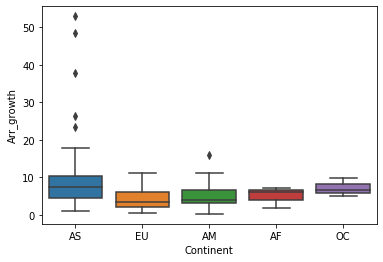

In [81]:
sns.boxplot(x=top_cities['Continent'], y=top_cities['Arr_growth'])

Some cities in Asia have discrepant arrivals growth rates. It can influence the analysis and thus the interpretation of the data. We choose to exclude those cities of our analysis.

In [82]:
p_25, p_75 = np.percentile(top_cities[top_cities['Continent'] == 'AS']['Arr_growth'].sort_values(), [25, 75])

iqr = p_75 - p_25
upper_bound = p_75 + 1.5 * iqr
lower_bound  = p_25 - 1.5 * iqr

top_cities = top_cities.drop(top_cities[(top_cities['Continent'] == 'AS') & (top_cities['Arr_growth'] > upper_bound)].index)
top_cities = top_cities.drop(top_cities[(top_cities['Continent'] == 'AS') & (top_cities['Arr_growth'] < lower_bound)].index)

We can check now number of venues we got from Foursquare API Let's see it in a bar chart. 

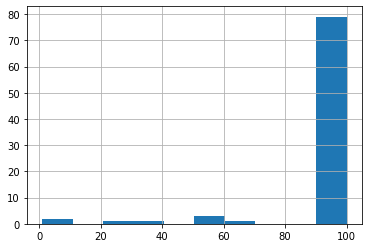

In [83]:
venues_count = top_cities_venues.groupby('City', as_index=False).count()
venues_count['City_lng'].hist(bins=10)

As we can see for some cities we got a small number of venues. We will assume for this project that minimum acceptable number of venues per city is 30. Let's drop cities whit numbers of venues below 30.

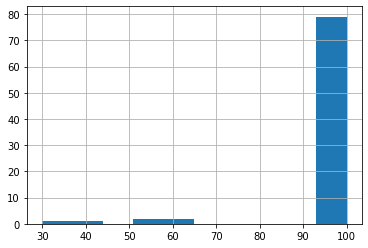

In [84]:
top_cities_venues = top_cities_venues[top_cities_venues.groupby('City')['Category_ID'].transform('count') >= 30]
venues_count = top_cities_venues.groupby('City', as_index=False).count()
venues_count['City_lng'].hist(bins=10)

Perfect! Now let's apply one-hot encoding in **top_cities_venues**.

In [85]:
top_cities_onehot = pd.get_dummies(top_cities_venues[['Category_group']], prefix="", prefix_sep="")

# add city name to top_cities_onehot
top_cities_onehot['City'] = top_cities_venues['City']
fixed_columns = [top_cities_onehot.columns[-1]]+ list(top_cities_onehot.columns[:-1])
top_cities_onehot = top_cities_onehot[fixed_columns]
top_cities_onehot.head()

,City,Arts & Culture,Entertainment,Food,Nature,Night Life,Shopping,Sports
0,Bangkok,0,0,1,0,0,0,0
1,Bangkok,0,0,1,0,0,0,0
2,Bangkok,0,0,0,0,0,1,0
3,Bangkok,0,0,1,0,0,0,0
4,Bangkok,0,0,1,0,0,0,0


Now we'll group **top_cities_onehot** by city and by taking the mean of the frequency of each category.

In [86]:
top_cities_grouped = top_cities_onehot.groupby('City').mean().reset_index()
top_cities_grouped = top_cities_grouped.join(top_cities[['City','Lat','Lng', 'Continent']].set_index('City'), on='City')
top_cities_grouped.dropna(inplace=True)
top_cities_grouped.shape

(80, 11)

Now we are able to start clustering. Our first step will be find best K to use in clustering algorithm. We'll apply K-Means Clustering Algorithm in **top_cities_grouped** setting K from 1 to 15 and plot the sums of squared distances.

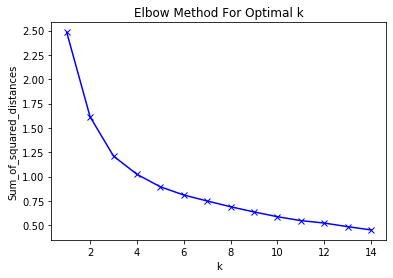

In [87]:
top_cities_clustering = top_cities_grouped.drop(['City', 'Lat', 'Lng', 'Continent'], axis=1)

Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(top_cities_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As k increases, the sum of squared distance tends to zero. If we set K to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero. Using Elbow Method we can see that K=3 is a good value to our dataset, so let's cluster using it!

In [88]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(top_cities_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0,
       1, 1, 0, 0, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0, 0, 1, 0], dtype=int32)

Now let's add some data to **top_cities_grouped** so we can plot each cluster in the map.

In [89]:
top_cities_grouped.insert(len(top_cities_grouped.columns), 'Cluster', kmeans.labels_)
top_cities_grouped

,City,Arts & Culture,Entertainment,Food,Nature,Night Life,Shopping,Sports,Lat,Lng,Continent,Cluster
1,Amsterdam,0.02,0.050000,0.410000,0.02000,0.090000,0.220000,0.040000,52.374540,4.897976,EU,1
2,Antalya,0.08,0.040000,0.330000,0.07000,0.110000,0.280000,0.040000,36.900964,30.695485,AS,0
3,Artvin,0.00,0.063492,0.444444,0.15873,0.111111,0.047619,0.063492,41.160506,41.839863,AS,1
4,Athens,0.08,0.040000,0.490000,0.02000,0.210000,0.120000,0.000000,37.984149,23.727984,EU,1
5,Auckland,0.04,0.050000,0.610000,0.05000,0.100000,0.050000,0.030000,-36.852095,174.763180,OC,2
...,...,...,...,...,...,...,...,...,...,...,...,...
80,Vancouver,0.05,0.010000,0.600000,0.09000,0.050000,0.090000,0.070000,49.260872,-123.113953,AM,2
81,Venice,0.13,0.060000,0.360000,0.03000,0.080000,0.100000,0.000000,45.437191,12.334590,EU,0
82,Vienna,0.12,0.140000,0.390000,0.03000,0.090000,0.080000,0.020000,48.208354,16.372504,EU,0
83,Warsaw,0.08,0.030000,0.450000,0.12000,0.150000,0.070000,0.060000,52.233717,21.071411,EU,1


In [ ]:
map_clusters = folium.Map(location=[0,25], zoom_start = 2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(top_cities_grouped['Lat'], 
                                  top_cities_grouped['Lng'], 
                                  top_cities_grouped['City'], 
                                  top_cities_grouped['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![](Data Science Project/Resources/cluster_map.PNG.PNG)

After clustering, let's explore each cluster to identify their main characteristics. First we can check size of each cluster.

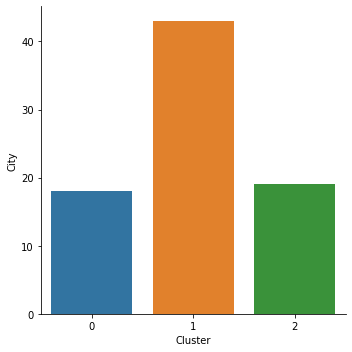

In [51]:
top_cities_barplot = top_cities_grouped.groupby('Cluster', as_index=False).count()
sns.catplot(x='Cluster', y='City', data = top_cities_barplot, kind='bar')

Cluster 1 is by far the most populated cluster. Clusters 0 and 2 have similar sizes. We can extract more information by checking continent distribution in each clusters.

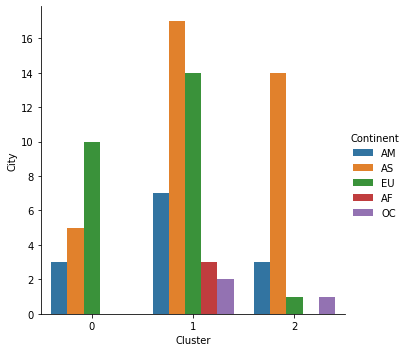

In [91]:
top_cities_contbarplot = top_cities_grouped.groupby(['Cluster', 'Continent'], as_index=False).count()
sns.catplot(x='Cluster', y='City', hue='Continent', data = top_cities_contbarplot, kind='bar')

We can see that majority of cities in cluster 0 belongs to Europe. Cluster 1 has cities spread by all continents. However, we can see that cities in Cluster 2 are majority located in Asian. Now go deeper into each cluster by analyzing boxplots.

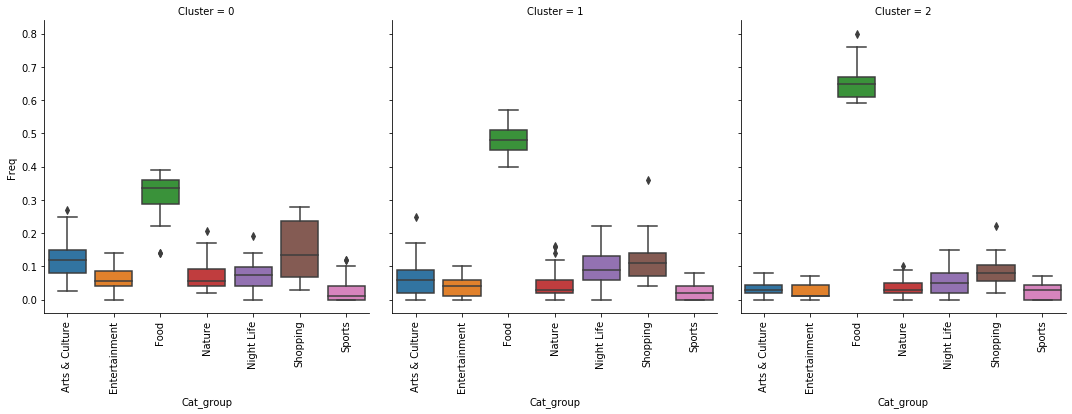

In [92]:
top_cities_boxplot = top_cities_grouped.melt(id_vars=['Cluster'], var_name='Cat_group', value_name='Freq')

top_cities_boxplot = top_cities_boxplot.drop(top_cities_boxplot[(top_cities_boxplot['Cat_group'] == 'Lat') 
                                                    | (top_cities_boxplot['Cat_group'] == 'Lng')
                                                    | (top_cities_boxplot['Cat_group'] == 'City')
                                                    | (top_cities_boxplot['Cat_group'] == 'Continent')].index)

top_cities_boxplot.reset_index(inplace=True)
sns.catplot(x='Cat_group', y='Freq', col='Cluster',data = top_cities_boxplot,kind='box').set_xticklabels(rotation=90)

We can conclude that **Cluster 0** holds best cities when visitors want to have a taste of each kind of experience. All kind of experiences are provided by those cities venues in a good reasonable proportion. In addiction, if visitors want to shopping, enjoy art and culture or see the nature definitely Cluster 0 should be their destiny. 

**Cluster** 1 is the largest cluster. It means its cities can be likely found near the visitors, what can make trips cheapest . Cities in this cluster offer a huge number of places to enjoy food. Places to enjoy night life and shopping can be found easily as well.

**Cluster** 2 is definitely recommended to visitor who prefer travel to enjoy food. Places to eat can be found everywhere. Despite that, we can't find a good number of places to enjoy other kind of experiences. Art & Culture and Nature options are the Achilles's heel of this Cluster.

In general, places to have fun and enjoy or do sports are similarly spread by clusters.

Finally, lets label each Cluster based on our analysis and print its cities. 

In [93]:
print('========================================')
print('Cluster 0 - Full Experience')
print('========================================')

for i, row in top_cities_grouped.iterrows():
    if row['Cluster'] == 0:
        print(row['City'])

Cluster 0 - Full Experience
Antalya
Berlin
Brussels
Florence
Guilin
Ha Long
Jerusalem
Kuala Lumpur
London
Milan
Moscow
New York City
Rome
Saint Petersburg
San Francisco
Venice
Vienna
Washington D.C.


In [94]:
print('========================================')
print('Cluster 1 - Eating, Partyng and Shopping')
print('========================================')

for i, row in top_cities_grouped.iterrows():
    if row['Cluster'] == 1:
        print(row['City'])

Cluster 1 - Eating, Partyng and Shopping
Amsterdam
Artvin
Athens
Bangkok
Barcelona
Budapest
Cairo
Colombo
Copenhagen
Dubai
Dublin
Edirne
Frankfurt am Main
Guangzhou
Heraklion
Jaipur
Johannesburg
Lima
Lisbon
Los Angeles
Madrid
Marrakesh
Mecca
Melbourne
Mexico City
Miami
Munich
Orlando
Osaka
Pattaya
Phnom Penh
Phuket
Prague
Punta Cana
Shanghai
Shenzhen
Siem Reap
Singapore
Stockholm
Sydney
Taipei
Toronto
Warsaw


In [95]:
print('========================================')
print('Cluster 2 - Food Everywhere ')
print('========================================')

for i, row in top_cities_grouped.iterrows():
    if row['Cluster'] == 2:
        print(row['City'])

Cluster 2 - Food Everywhere 
Auckland
Cancún
Chennai
Chiang Mai
Dammam
Doha
Hanoi
Honolulu
Johor Bahru
Kolkata
Kyoto
Macau
Penang Island
Rhodes
Riyadh
Taichung
Tel Aviv
Tokyo
Vancouver


## Results and Discussion <a name="results"></a>

Our analysis shows that majority of most visited cities are located in Europe and Asia. Some of those cities has not enough information about venues in Foursquare. It doesn't mean that those cities have a small number of options to offer to their visitors. We focused on cities with at least thirty places registered in Foursquare near their city centers.

After directing our attention to this more narrow area, we choose to ignore cities in Asia with discrepant arrivals growth rates. It can influence the analysis and thus the interpretation of the data. 

We found best number of clusters by analyzing squared distances when running K-Mean Clustering Algorithm for a range of values for K.

Clusters got from K-Mean Algorithm shows that we can split cities in three main clusters. First one holds cities indicated to visitors who wants to experience all kind of experiences, like shopping and  enjoy nature and arts. Cities in this cluster are mainly located in Europe and Asia.

Second cluster is indicated to visitors who wants to spend less money to reach their final destination, enjoy food or experience a intense night life.

Third cluster is heavily recommended to visitors who are looking for cities to enjoy food. Most of cities in this cluster have more than 65% of their places focused on food tourism.

 In general, places to have fun and enjoy or do sports figure similarly in all clusters.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify similarity between most visited cities to aid stakeholders make customized suggestions.

By clustering most visited cities in the world we have created groups of similar cities based on their venues categories. Those groups will help stakeholders to make customized suggestions based on their client's preferences.